In [14]:
import io
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras

# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential

from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Dense, Input, Lambda, LSTM

In [15]:
#function to plot a series
def plot_series(x, y, type_=None, ylabel=None, format="-", start=None, end=None, label=None, multi_plot=True):
    if not multi_plot:
        plt.figure(figsize=(20, 10))
    plt.plot(x[start:end], y[start:end], format, label=label)
    plt.xlabel("Date", labelpad=50, fontsize=14)
    plt.ylabel(f"{ylabel} Volume", labelpad=50, fontsize=14)
    if label:
        plt.legend(fontsize=14)
    plt.grid(True, which='both')
    x_ticks = x.to_list()
    x_max = max(x_ticks)
    x_ticks = x_ticks[::round(len(x_ticks)/10)]
    x_ticks.append(x_max)
    plt.xticks(x_ticks, rotation = 30)
    if not multi_plot:
        plt.savefig(f'../plots/{ylabel.lower()}/{ylabel.lower()}_{type_}_time_series.png')
        plt.show()


#clear session 
def refresh():
    keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)

class ResetStatesCallback(Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

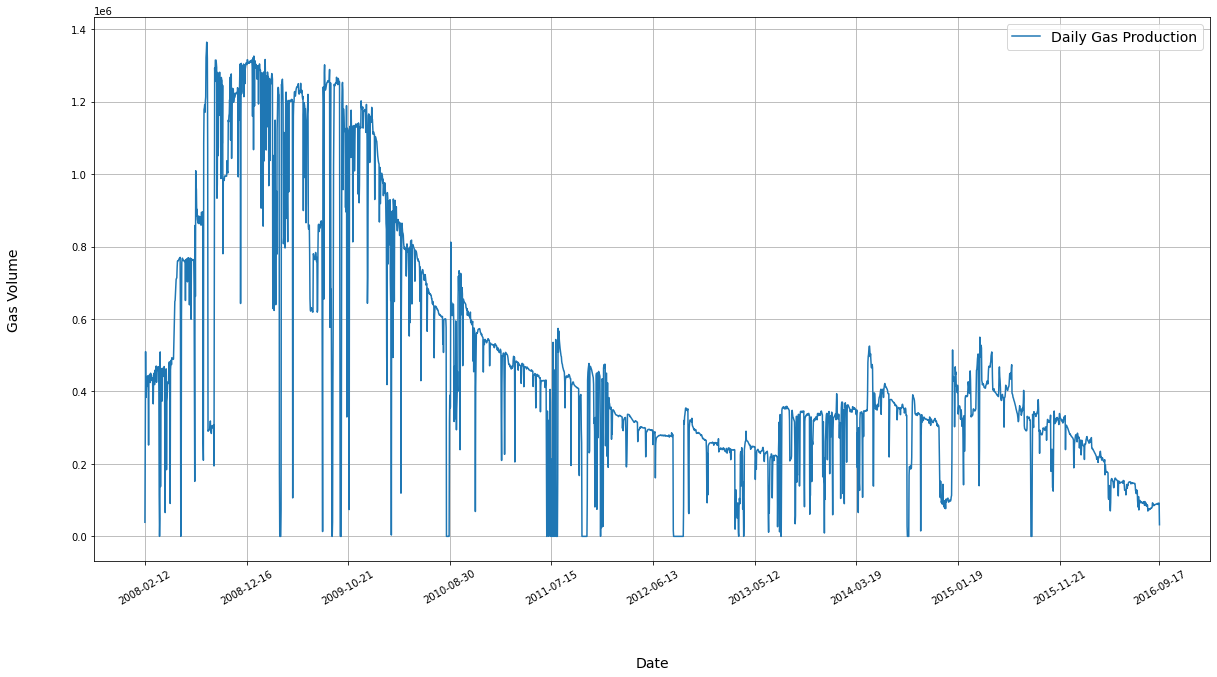

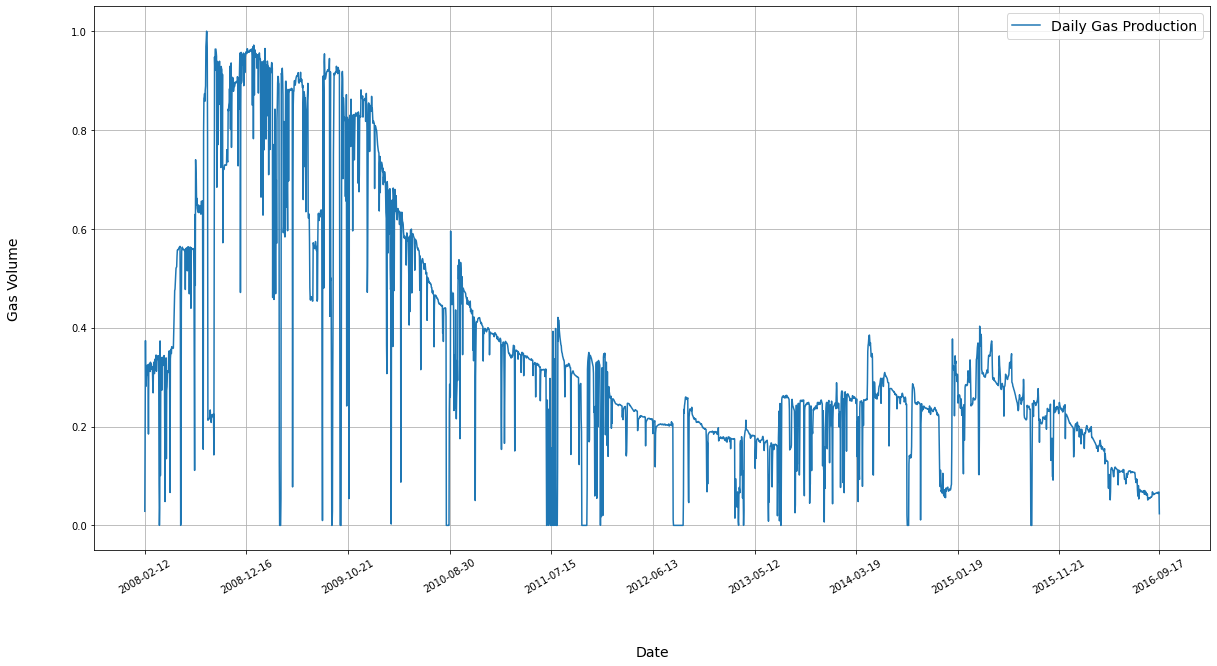

(2140,) (2140,) (916,) (916,)


In [16]:
df = pd.read_csv("../datasets/consolidated_data/gas_data.csv", index_col="DATEPRD")
date = df.index

gas_data = df.BORE_GAS_VOL.to_numpy()
plot_series(date, gas_data, "unscaled", "Gas", label="Daily Gas Production", multi_plot=False)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled, index=df.index, columns=df.columns)

scaled_gas_data = scaled_df.BORE_GAS_VOL.to_numpy()
plot_series(date, scaled_gas_data, "scaled", "Gas", label="Daily Gas Production", multi_plot=False)


#split the time series into training and validation sets
split_date = 2140

date_train = date[:split_date]
date_valid = date[split_date:]

gas_train = scaled_gas_data[:split_date]
gas_valid = scaled_gas_data[split_date:]

print(date_train.shape, gas_train.shape, date_valid.shape, gas_valid.shape)

In [6]:
def window_dataset(series, window_size, batch_size=30, shuffle_buffer=100):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(2)
    
    return dataset


def sequential_window_dataset(series, window_size):
    
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=window_size, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[1:]))
    
    return dataset.batch(1).prefetch(1)


def forecast_model(model, series, window_size):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(30).prefetch(2)
    
    forecast = model.predict(dataset)
    
    return forecast


def plot_model_forecast (model, file_name, label, window_size=None):
    if label=="LSTM":
        forecast = model.predict(scaled_gas_data[np.newaxis, :, np.newaxis])[0, split_date - 1:-1, 0]
    else:
        forecast = forecast_model(model, scaled_gas_data[split_date - window_size:-1], window_size)[:, 0]

    plt.figure(figsize=(20, 10))

    plot_series(date_valid, gas_valid, ylabel="Gas", label="Actual")
    plot_series(date_valid, forecast, ylabel="Gas", label=f"{label} Model")

    plt.savefig(f'../plots/gas/{file_name}.png')
    plt.show()

    mae = keras.metrics.mean_absolute_error(gas_valid, forecast).numpy()
    mse = keras.metrics.mean_squared_error(gas_valid, forecast).numpy()
    rmse = math.sqrt(mse)

    print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

In [7]:
def model_linear(callbacks, window_size=30, epochs=500, learning_rate=1e-3, file_name=None):
    refresh()

    gas_train_set = window_dataset(gas_train, window_size)
    gas_valid_set = window_dataset(gas_valid, window_size)

    model = Sequential( [ Dense(1, input_shape=[window_size]) ] )

    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(loss=keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"])

    history = model.fit(
        
        gas_train_set,
        epochs=epochs,
        validation_data=gas_valid_set,
        callbacks=callbacks

    )

    if file_name:
        model.save(f'linear/{file_name}.h5')

    return history, model

def model_ffnn(callbacks, window_size=30, units=10, learning_rate=1e-3, epochs=500, file_name="None"):
    refresh()

    gas_train_set = window_dataset(gas_train, window_size)
    gas_valid_set = window_dataset(gas_valid, window_size)

    model = Sequential([
                Dense(units, activation="relu", input_shape=[window_size]),
                Dense(units, activation="relu"),
                Dense(1)
            ])

    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(loss=keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"])


    history = model.fit(gas_train_set,
            epochs=epochs,
            validation_data=gas_valid_set,
            callbacks=callbacks)

    if file_name:
        model.save(f'ffnn/{file_name}.h5')

    return history, model
    
def model_lstm(callbacks, window_size=30, units=10, learning_rate=1e-3, epochs=500, file_name="None"):
    refresh()

    gas_train_set = sequential_window_dataset(gas_train, window_size)
    gas_valid_set = sequential_window_dataset(gas_valid, window_size)

    model = Sequential([
    
        LSTM(units, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
        LSTM(units, return_sequences=True, stateful=True),
        Dense(1)
    
        ])

    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(loss=keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"])


    history = model.fit(gas_train_set,
            epochs=epochs,
            validation_data=gas_valid_set,
            callbacks=callbacks)

    if file_name:
        model.save(f'lstm/{file_name}.h5')

    return history, model

# Linear Model

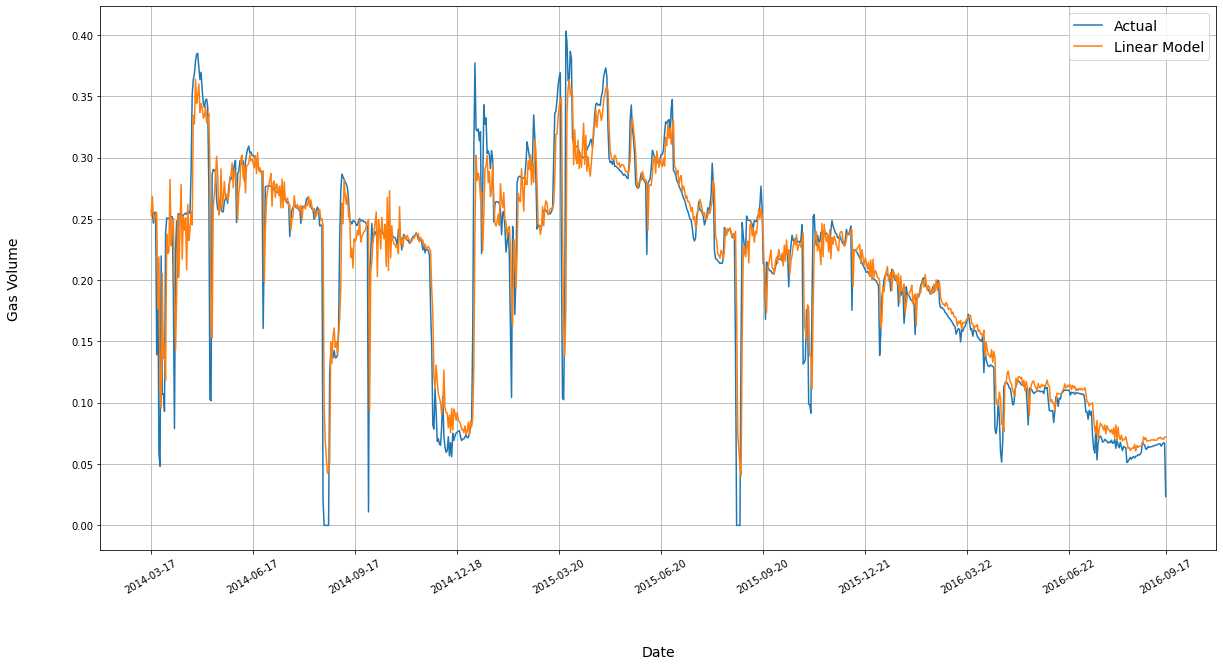

mae = 0.016262970864772797, 
mse = 0.0009474352700635791, 
rmse = 0.030780436482668323
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 31        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'dense/kernel:0' shape=(30, 1) dtype=float32, numpy=
array([[ 0.00915948],
       [ 0.03930292],
       [-0.09717624],
       [ 0.03843413],
       [ 0.01170989],
       [ 0.03488468],
       [ 0.01859706],
       [ 0.04115361],
       [ 0.0027131 ],
       [-0.0241794 ],
       [ 0.09344763],
       [-0.15943672],
       [ 0.14151964],
       [-0.1385156 ],
       [ 0.12101036],
       [-0.04157323],
       [ 0.03091143],
       [ 0.01007875],
       [-0.06715616],
       [ 0.08570512],
       [-0.00472662],
       [-0.07842366],
       [ 0.16493

In [10]:

# lr_schedule = LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 30))
# history, model = linear_model(callbacks=[lr_schedule])

# plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([5e-5, 5e-1, 0, 0.3])
# plt.show()

# max(history.history["loss"])

# early_stopping = EarlyStopping(patience=10)
# linear_history, linear_model = model_linear(callbacks=[early_stopping], file_name="linear_gas_model")
linear_model = keras.models.load_model("linear/linear_gas_model.h5")

plot_model_forecast(linear_model, "gas_linear_forecast", "Linear", window_size=30)
linear_model.summary()
print(linear_model.trainable_variables)

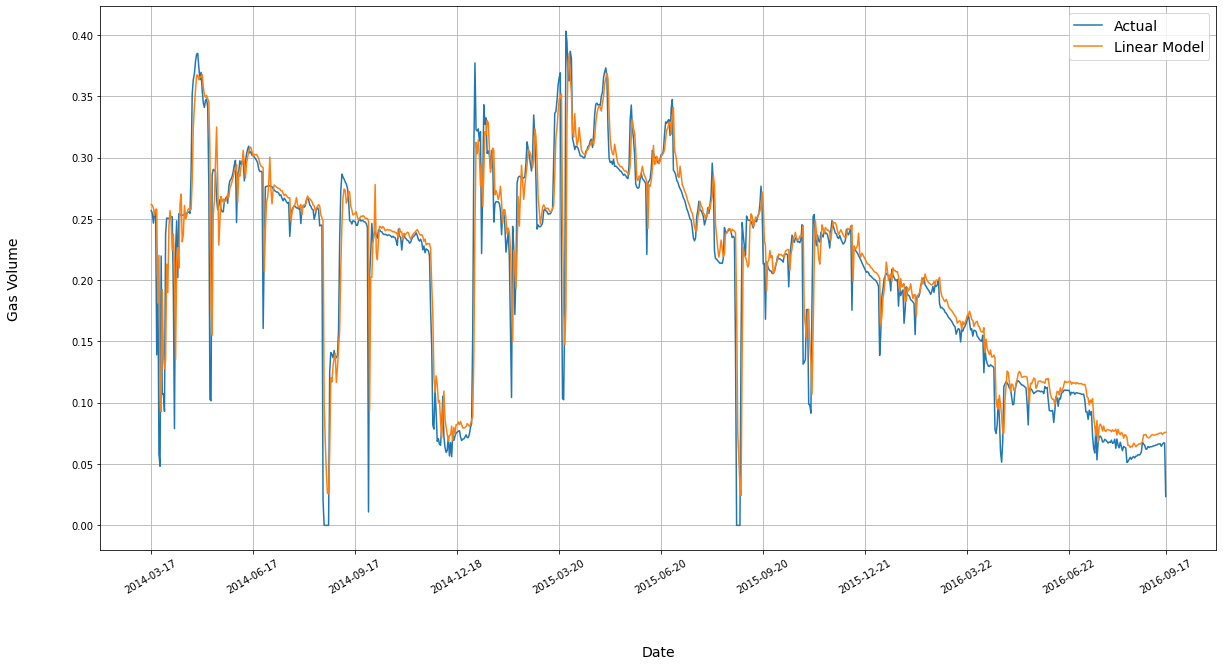

mae = 0.015757091343402863, 
mse = 0.0009352025808766484, 
rmse = 0.03058108207497976
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'dense/kernel:0' shape=(8, 1) dtype=float32, numpy=
array([[ 0.09907673],
       [ 0.11581515],
       [-0.1551119 ],
       [-0.00843579],
       [ 0.05434345],
       [ 0.11816936],
       [ 0.08138622],
       [ 0.66289634]], dtype=float32)>, <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.01128497], dtype=float32)>]


In [18]:
# early_stopping = EarlyStopping(patience=10)
# linear_history, linear_model = model_linear(callbacks=[early_stopping], window_size=8, file_name="optimized_linear_model")
linear_model = keras.models.load_model("linear/optimized_linear_model.h5")

plot_model_forecast(linear_model, "gas_linear_optimized_forecast", "Linear", window_size=8)
linear_model.summary()
print(linear_model.trainable_variables)

#  FF-NN

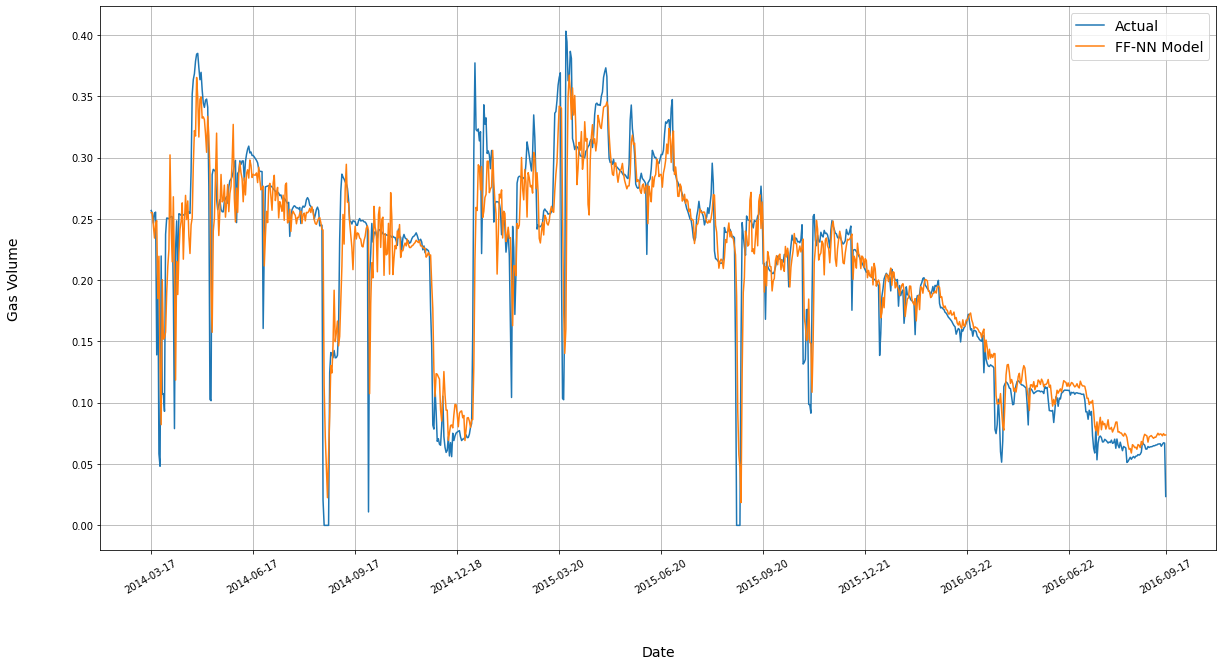

mae = 0.019211512058973312, 
mse = 0.0011159389978274703, 
rmse = 0.033405673138367835
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                310       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'dense/kernel:0' shape=(30, 10) dtype=float32, numpy=
array([[ 0.20406866,  0.11649283, -0.3765996 , -0.12793078, -0.01066834,
        -0.05361056, -0.32081467, -0.37077764, -0.15673453, -0.01955002],
       [ 0.13462754, -0.3090755 ,  0.33171946, -0.24820738,  0.13362546,
         0.04

In [12]:

# lr_schedule = LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))
# history, model = linear_model(callbacks=[lr_schedule])

# plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([1e-5, 1, 0, 0.12])
# plt.show()

# max(history.history["loss"])

# early_stopping = EarlyStopping(patience=10)
# ffnn_history, ffnn_model = model_ffnn(callbacks=[early_stopping], file_name="ffnn_gas_model")
ffnn_model = keras.models.load_model("ffnn/ffnn_gas_model.h5")

plot_model_forecast(ffnn_model, "gas_ffnn_forecast", "FF-NN", window_size=30)
ffnn_model.summary()
print(ffnn_model.trainable_variables)

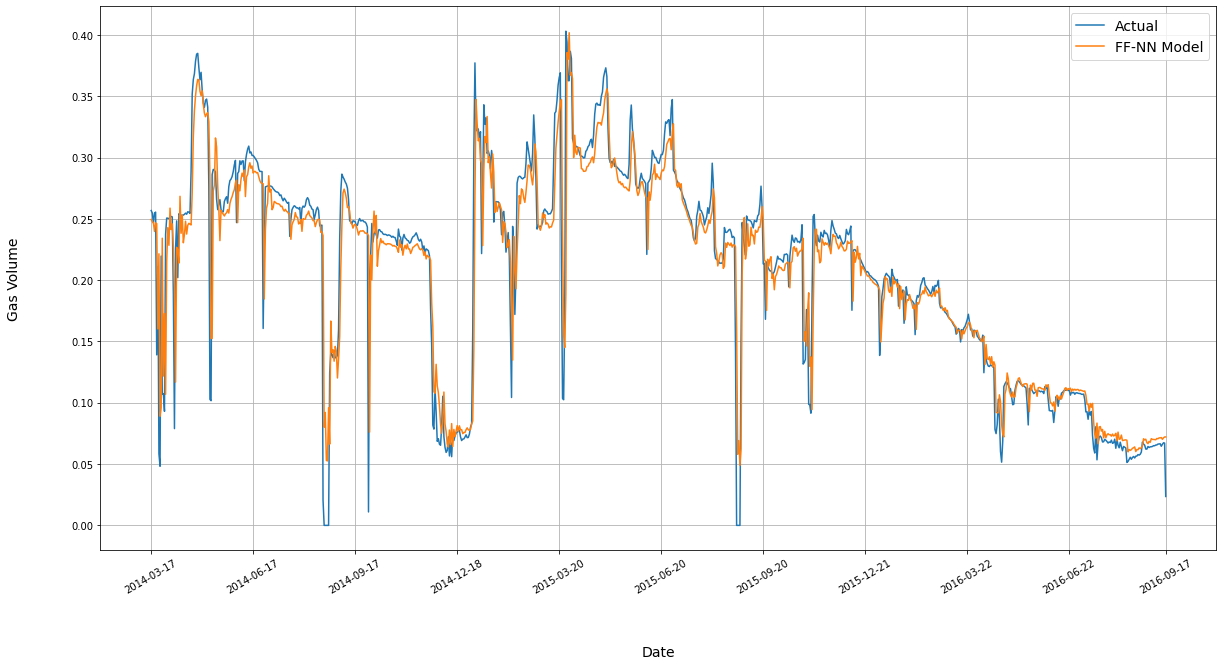

mae = 0.01584205962717533, 
mse = 0.0008781823562458158, 
rmse = 0.02963414173290355
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 29)                261       
_________________________________________________________________
dense_1 (Dense)              (None, 29)                870       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 30        
Total params: 1,161
Trainable params: 1,161
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'dense/kernel:0' shape=(8, 29) dtype=float32, numpy=
array([[ 1.99729756e-01,  9.91337225e-02, -3.77601087e-01,
        -1.27871633e-01,  1.28606940e-02, -1.17589846e-01,
        -3.65809351e-01, -3.85482281e-01, -1.84631094e-01,
         2.59078748e-04,  1.52532414e-01, -3.43728542e-

In [19]:
# early_stopping = EarlyStopping(patience=10)
# ffnn_history, ffnn_model = model_ffnn(callbacks=[early_stopping], window_size=8, file_name="optimized_ffnn_model")

ffnn_model = keras.models.load_model("ffnn/optimized_ffnn_model.h5")

plot_model_forecast(ffnn_model, "gas_ffnn_optimized_forecast", "FF-NN", window_size=8)
ffnn_model.summary()
print(ffnn_model.trainable_variables)

# RNN Model - LSTM

In [ ]:
refresh()

window_size = 30

gas_train_set = sequential_window_dataset(gas_train, window_size)

model = Sequential([
    
        LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
        LSTM(100, return_sequences=True, stateful=True),
        Dense(1)
    
        ])

learning_rate_schedule = LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)

model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(gas_train_set, epochs=100, callbacks=[learning_rate_schedule, reset_states])

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 10, 0.009, 0.12])
plt.show()

max(history.history["lr"])

In [9]:
refresh()

window_size = 30
gas_train_set = sequential_window_dataset(gas_train, window_size)
gas_valid_set = sequential_window_dataset(gas_valid, window_size)

model = Sequential([
                    
        LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
        LSTM(100, return_sequences=True, stateful=True),
        Dense(1)
        
        ])

optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

reset_states = ResetStatesCallback()
model_checkpoint = ModelCheckpoint("lstm/LSTM_gas_checkpoint.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=50)

history = model.fit(gas_train_set, epochs=500, validation_data=gas_valid_set, 
          callbacks=[early_stopping, model_checkpoint, reset_states])

model.save('lstm/lstm_gas_model.h5')

Epoch 1/500
71/71 [==============================] - 16s 79ms/step - loss: 0.0815 - mae: 0.3177 - val_loss: 0.0071 - val_mae: 0.0974
Epoch 2/500
71/71 [==============================] - 3s 35ms/step - loss: 0.0345 - mae: 0.2175 - val_loss: 0.0054 - val_mae: 0.0825
Epoch 3/500
71/71 [==============================] - 2s 30ms/step - loss: 0.0298 - mae: 0.2001 - val_loss: 0.0044 - val_mae: 0.0738
Epoch 4/500
71/71 [==============================] - 2s 30ms/step - loss: 0.0254 - mae: 0.1826 - val_loss: 0.0035 - val_mae: 0.0651
Epoch 5/500
71/71 [==============================] - 2s 32ms/step - loss: 0.0216 - mae: 0.1661 - val_loss: 0.0028 - val_mae: 0.0571
Epoch 6/500
71/71 [==============================] - 2s 33ms/step - loss: 0.0183 - mae: 0.1505 - val_loss: 0.0022 - val_mae: 0.0500
Epoch 7/500
71/71 [==============================] - 2s 32ms/step - loss: 0.0156 - mae: 0.1360 - val_loss: 0.0018 - val_mae: 0.0440
Epoch 8/500
71/71 [==============================] - 2s 31ms/step - loss: 0

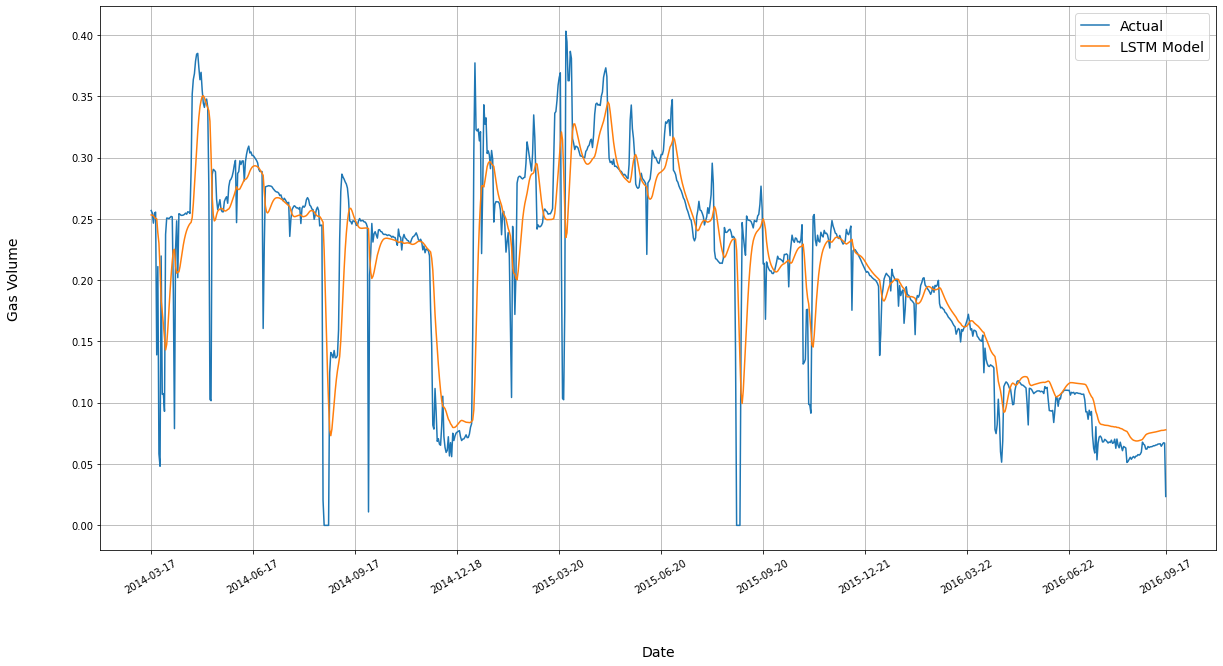

mae = 0.023276330903172493, 
mse = 0.0017854965990409255, 
rmse = 0.042255136954468926
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, None, 100)            40800     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 100)            80400     
_________________________________________________________________
dense (Dense)                (1, None, 1)              101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'lstm/lstm_cell/kernel:0' shape=(1, 400) dtype=float32, numpy=
array([[ 3.97784114e-02, -1.41512379e-02, -3.52972522e-02,
        -8.05603713e-03, -1.13467135e-01,  4.81447838e-02,
         5.83619289e-02,  9.18634087e-02, -6.74388781e-02,
        -6.00730851e-02, -4.02533896e-0

In [10]:
#forecast
LSTM_gas_forecast = model.predict(scaled_gas_data[np.newaxis, :, np.newaxis])
LSTM_gas_forecast = LSTM_gas_forecast[0, split_date - 1:-1, 0]

plt.figure(figsize=(20, 10))

plot_series(date_valid, gas_valid, ylabel="Gas", label="Actual")
plot_series(date_valid, LSTM_gas_forecast, ylabel="Gas", label="LSTM Model")

plt.savefig(f'../plots/gas/gas_lstm_forecast.png')
plt.show()

mae = keras.metrics.mean_absolute_error(gas_valid, LSTM_gas_forecast).numpy()
mse = keras.metrics.mean_squared_error(gas_valid, LSTM_gas_forecast).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

model.summary()
print(model.trainable_variables)

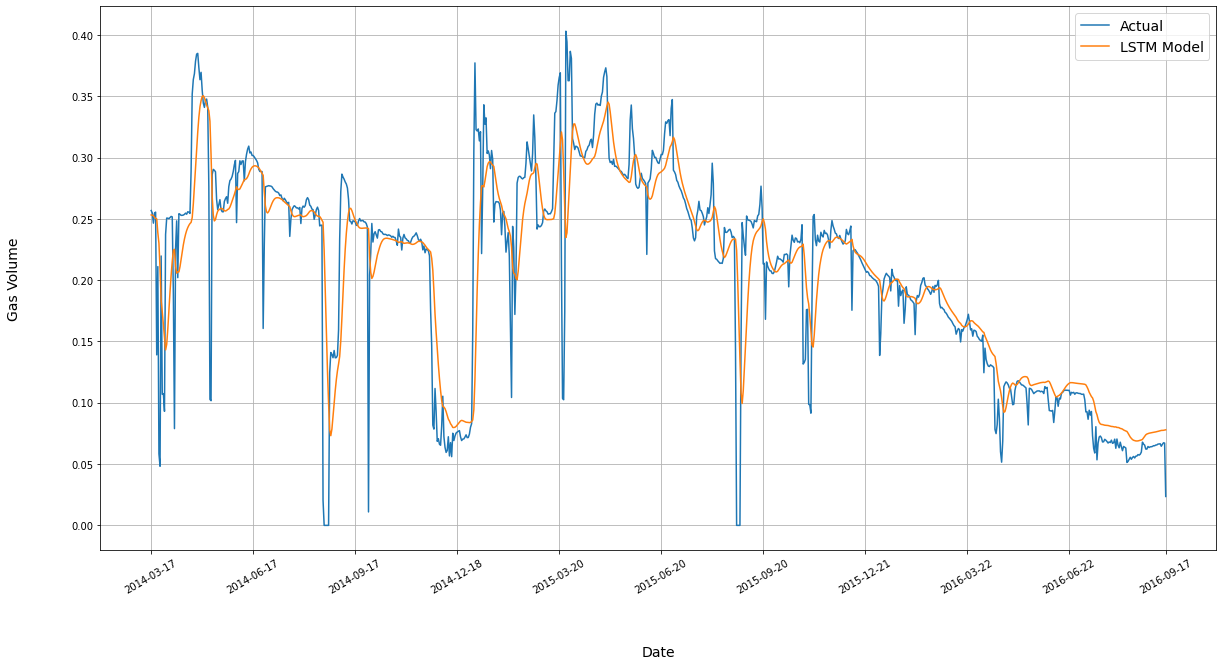

mae = 0.023276330903172493, 
mse = 0.0017854965990409255, 
rmse = 0.042255136954468926
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, None, 100)            40800     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 100)            80400     
_________________________________________________________________
dense (Dense)                (1, None, 1)              101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'lstm/lstm_cell/kernel:0' shape=(1, 400) dtype=float32, numpy=
array([[ 3.97784114e-02, -1.41512379e-02, -3.52972522e-02,
        -8.05603713e-03, -1.13467135e-01,  4.81447838e-02,
         5.83619289e-02,  9.18634087e-02, -6.74388781e-02,
        -6.00730851e-02, -4.02533896e-0

In [13]:

# learning_rate_schedule = LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))
# reset_states = ResetStatesCallback()
# lstm_history, lstm_model = model_lstm(callbacks=[learning_rate_schedule, reset_states])

# plt.semilogx(lstm_history.history["lr"], lstm_history.history["loss"])
# plt.axis([1e-5, 10, 0.009, 0.12])
# plt.show()

# max(lstm_history.history["lr"])

# reset_states = ResetStatesCallback()
# model_checkpoint = ModelCheckpoint("lstm/LSTM_gas_checkpoint.h5", save_best_only=True)
# early_stopping = EarlyStopping(patience=50)
# lstm_history, lstm_model = model_lstm(callbacks=[early_stopping, model_checkpoint, reset_states], file_name="lstm_gas_model")
lstm_model = keras.models.load_model("lstm/lstm_gas_model.h5")

plot_model_forecast(lstm_model, file_name="gas_lstm_forecast", label="LSTM")
lstm_model.summary()
print(lstm_model.trainable_variables)
